In [161]:
import numpy as np
from math import factorial
import scipy.special as sp
import matplotlib.pyplot as plt

In [162]:

def hankel_2(ell, kr):
    return sp.spherical_jn(ell, kr) - 1j * sp.spherical_yn(ell, kr)


def DV_hankel_2(ell, kr):
    return sp.spherical_jn(ell, kr, True) - 1j * sp.spherical_yn(ell, kr, True)



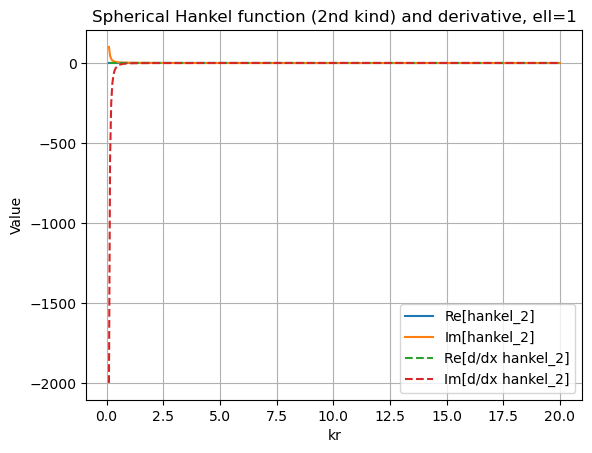

In [163]:
# plot hankel2 and DV_hankel_2
# Parameters
ell = 1 # spherical order
kr = np.linspace(0.1, 20, 400) # avoid kr=0 since spherical_yn diverges

# Evaluate functions
h = hankel_2(ell, kr)
dh = DV_hankel_2(ell, kr)

# Plot

plt.plot(kr, h.real, label='Re[hankel_2]')
plt.plot(kr, h.imag, label='Im[hankel_2]')
plt.plot(kr, dh.real, '--', label='Re[d/dx hankel_2]')
plt.plot(kr, dh.imag, '--', label='Im[d/dx hankel_2]')

plt.title(f"Spherical Hankel function (2nd kind) and derivative, ell={ell}")
plt.xlabel("kr")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


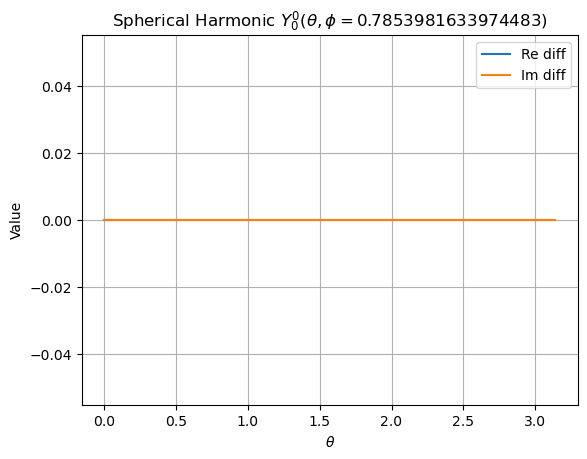

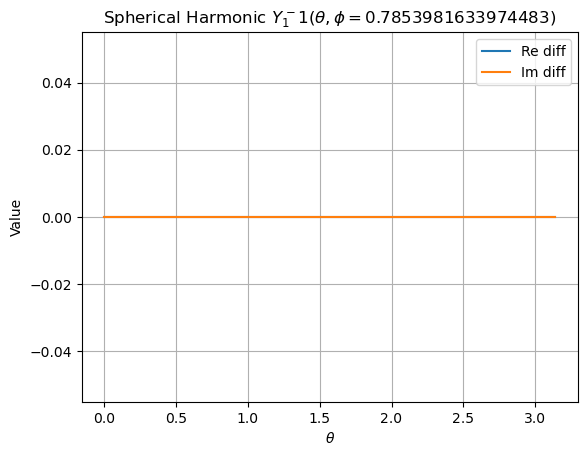

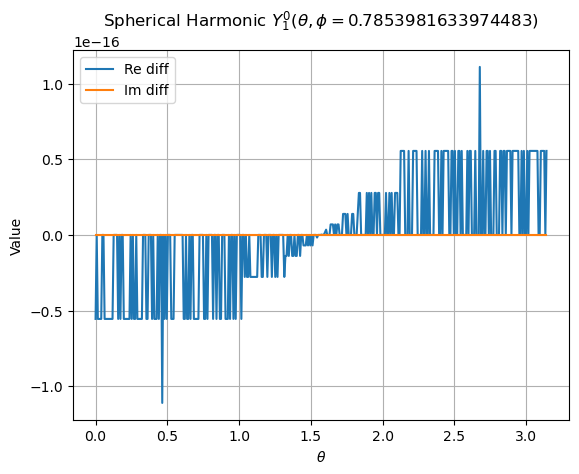

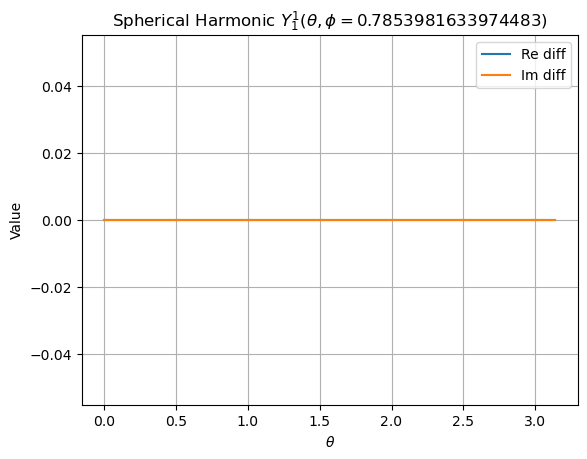

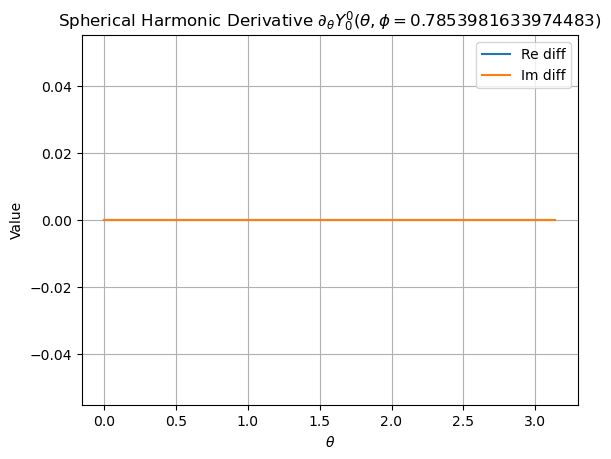

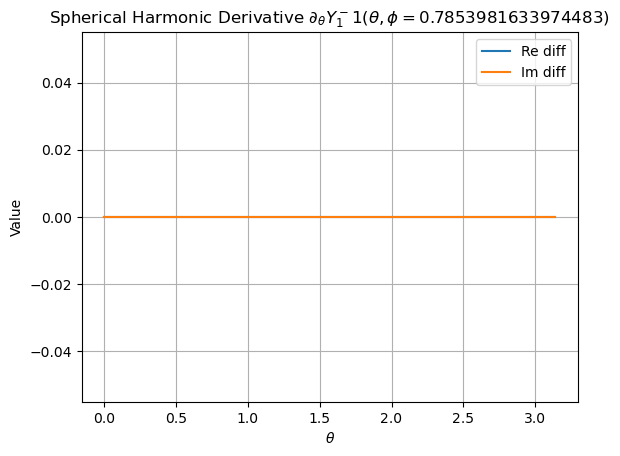

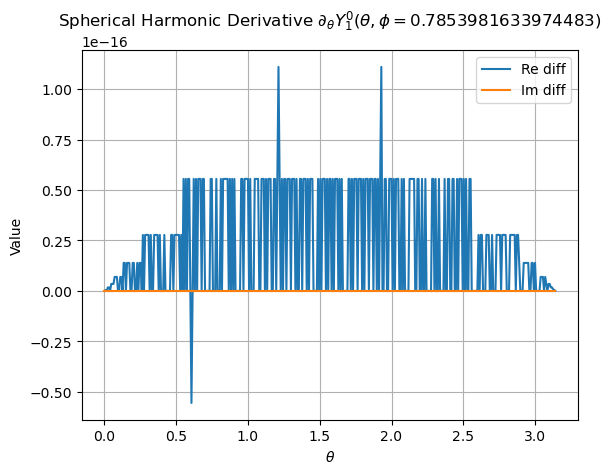

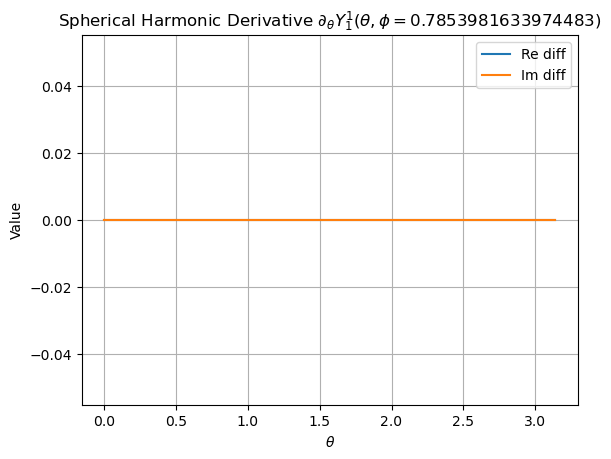

In [164]:
def analytical_Y(ell, m, theta, phi):
    if ell == 0 and m == 0:
        return np.sqrt(1 / (4 * np.pi)) * np.ones_like(theta, dtype=complex)
    elif ell == 1:
        if m == -1:
            return np.sqrt(3 / (8 * np.pi)) * np.sin(theta) * np.exp(-1j * phi)
        elif m == 0:
            return np.sqrt(3 / (4 * np.pi)) * np.cos(theta)
        elif m == 1:
            return -np.sqrt(3 / (8 * np.pi)) * np.sin(theta) * np.exp(1j * phi)
        
def analytical_Y_dv(ell, m, theta, phi):
    if ell == 0 and m == 0:
        return 0 * np.ones_like(theta, dtype=complex)
    elif ell == 1:
        if m == -1:
            return np.sqrt(3 / (8 * np.pi)) * np.cos(theta) * np.exp(-1j * phi)
        elif m == 0:
            return -np.sqrt(3 / (4 * np.pi)) * np.sin(theta)
        elif m == 1:
            return -np.sqrt(3 / (8 * np.pi)) * np.cos(theta) * np.exp(1j * phi)



# Parameters
pairs = [(0,0), (1,-1), (1,0), (1,1)]
phi = np.pi/4
theta = np.linspace(0, np.pi, 400)

for ell, m in pairs:
    Y = sp.sph_harm_y(ell, m, theta, phi)  # order: (m, ell, phi, theta)
    Y_analytical = analytical_Y(ell, m, theta, phi)

    Y_diff = Y - Y_analytical

    # plt.plot(theta, Y_analytical.real, label=f'Re Analytical')
    # plt.plot(theta, Y_analytical.imag, '--', label=f'Im Analytical')

    # plt.plot(theta, Y.real, label=f'Re SciPy')
    # plt.plot(theta, Y.imag, '--', label=f'Im SciPy')

    plt.plot(theta, Y_diff.real, '-', label=f'Re diff')
    plt.plot(theta, Y_diff.imag, '-', label=f'Im diff')

    plt.title(f'Spherical Harmonic $Y_{ell}^{m}(\\theta, \\phi={phi})$')
    plt.xlabel(r'$\theta$')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


for ell, m in pairs:
    Y, Y_dv = sp.sph_harm_y(ell, m, theta, phi, diff_n=1)  # order: (m, ell, phi, theta)
    Y_analytical_dv = analytical_Y_dv(ell, m, theta, phi)

    Y_dv_diff = Y_dv[:,0] - Y_analytical_dv

    # plt.plot(theta, Y_analytical_dv.real, label=f'Re Analytical')
    # plt.plot(theta, Y_analytical_dv.imag, '--', label=f'Im Analytical')

    # plt.plot(theta, Y_dv[:,0].real, label=f'Re SciPy')
    # plt.plot(theta, Y_dv[:,0].imag, '--', label=f'Im SciPy')

    plt.plot(theta, Y_dv_diff.real, '-', label=f'Re diff')
    plt.plot(theta, Y_dv_diff.imag, '-', label=f'Im diff')

    plt.title(f'Spherical Harmonic Derivative $\\partial_\\theta Y_{ell}^{m}(\\theta, \\phi={phi})$')
    plt.xlabel(r'$\theta$')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()




In [165]:
def Psi(ell, m, r, theta, phi):
    h2 = hankel_2(ell, r)
    Y = sp.sph_harm_y(ell, m, theta, phi)
    return h2 * Y


In [180]:
def NormalDVPsiGradient(ell, m, r, theta, phi):
    k = 1
    kr = k * r

    # Spherical harmonics and derivative wrt theta
    Y = sp.sph_harm_y(ell, m, theta, phi)           # shape (N,), complex
    Y, Y_dv = sp.sph_harm_y(ell, m, theta, phi, diff_n=1)

    grad_r = k * DV_hankel_2(ell, kr) * Y
    grad_theta = (1/r) * hankel_2(ell, kr) * Y_dv[:,0]
    grad_phi = (1 / (r * np.sin(theta))) * hankel_2(ell, kr) * Y_dv[:,1]

    grad = np.array([grad_r, grad_theta, grad_phi])
    return grad


In [181]:
def Psi(ell, m, r, theta, phi):
    h2 = hankel_2(ell, r)
    Y = sp.sph_harm_y(ell, m, theta, phi)
    return h2 * Y

def spherical_gradient(f_vals, r, theta, phi, vary):

    if vary == "r":
        df_dr = np.gradient(f_vals, r, edge_order=2)
        grad_r = df_dr
        grad_theta = np.zeros_like(f_vals)
        grad_phi = np.zeros_like(f_vals)

    elif vary == "theta":
        df_dtheta = np.gradient(f_vals, theta, edge_order=2)
        grad_r = np.zeros_like(f_vals)
        grad_theta = df_dtheta / r  # r is scalar here
        grad_phi = np.zeros_like(f_vals)

    elif vary == "phi":
        df_dphi = np.gradient(f_vals, phi, edge_order=2)
        grad_r = np.zeros_like(f_vals)
        grad_theta = np.zeros_like(f_vals)
        grad_phi = df_dphi / (r * np.sin(theta))  # r, theta are scalars here

    else:
        raise ValueError("vary must be one of {'r', 'theta', 'phi'}")

    return grad_r, grad_theta, grad_phi


Plotting NormalDV_theta0_0.txt...


/var/folders/3k/hy9hsqdx2rn3xs7l4zq8q6480000gn/T/ipykernel_24919/364881539.py:11: RuntimeWarning: divide by zero encountered in divide
  grad_phi = (1 / (r * np.sin(theta))) * hankel_2(ell, kr) * Y_dv[:,1]
/var/folders/3k/hy9hsqdx2rn3xs7l4zq8q6480000gn/T/ipykernel_24919/364881539.py:11: RuntimeWarning: invalid value encountered in multiply
  grad_phi = (1 / (r * np.sin(theta))) * hankel_2(ell, kr) * Y_dv[:,1]


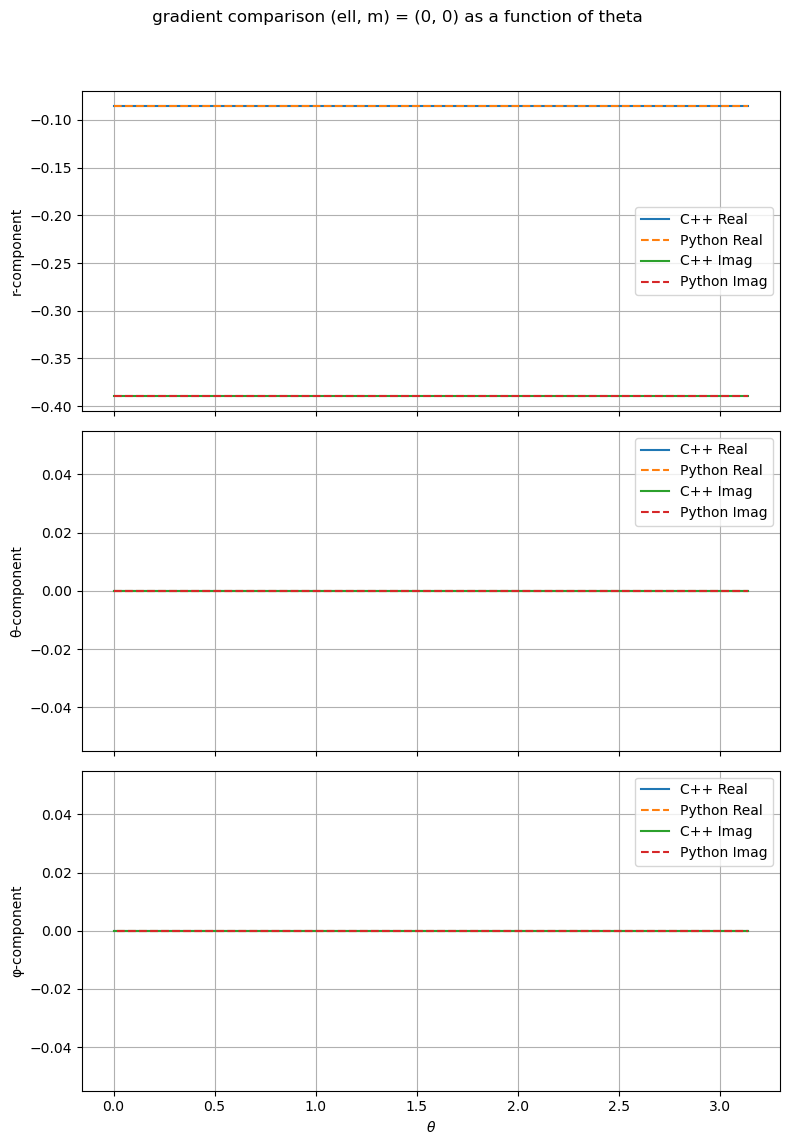

Plotting NormalDV_phi0_0.txt...


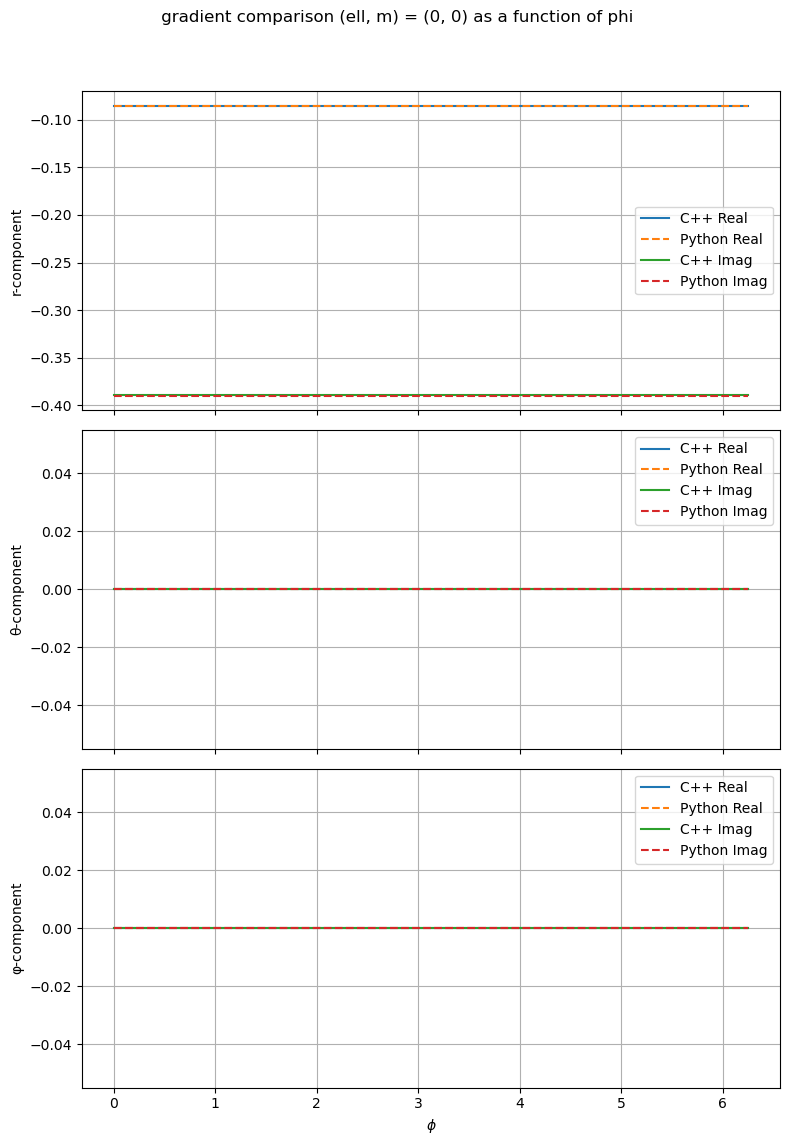

Plotting NormalDV_phi1_0.txt...


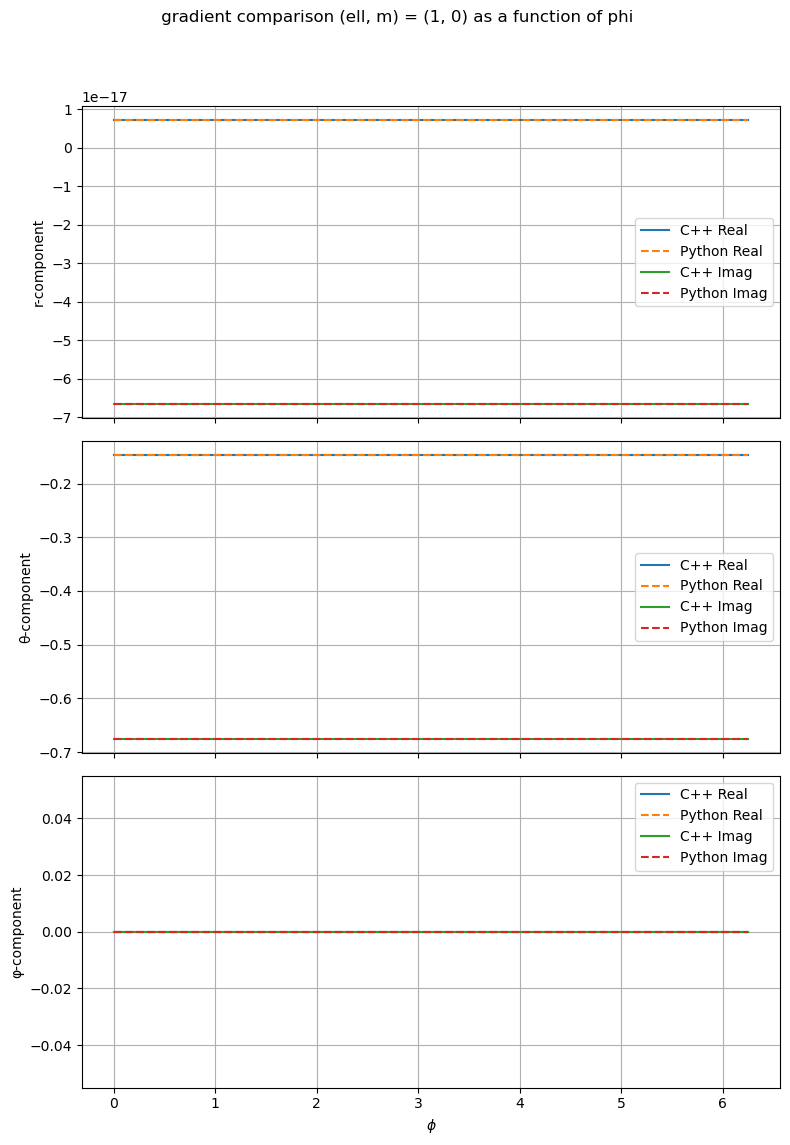

Plotting NormalDV_theta1_0.txt...


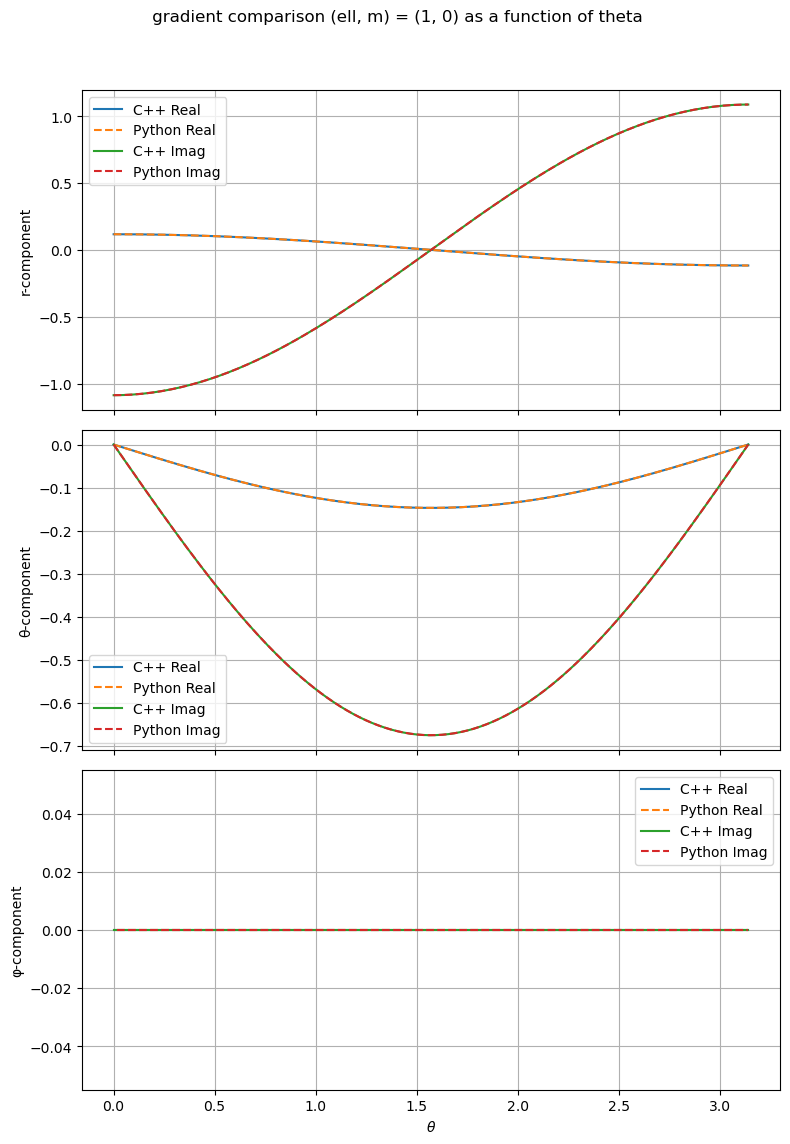

Plotting NormalDV_theta1_1.txt...


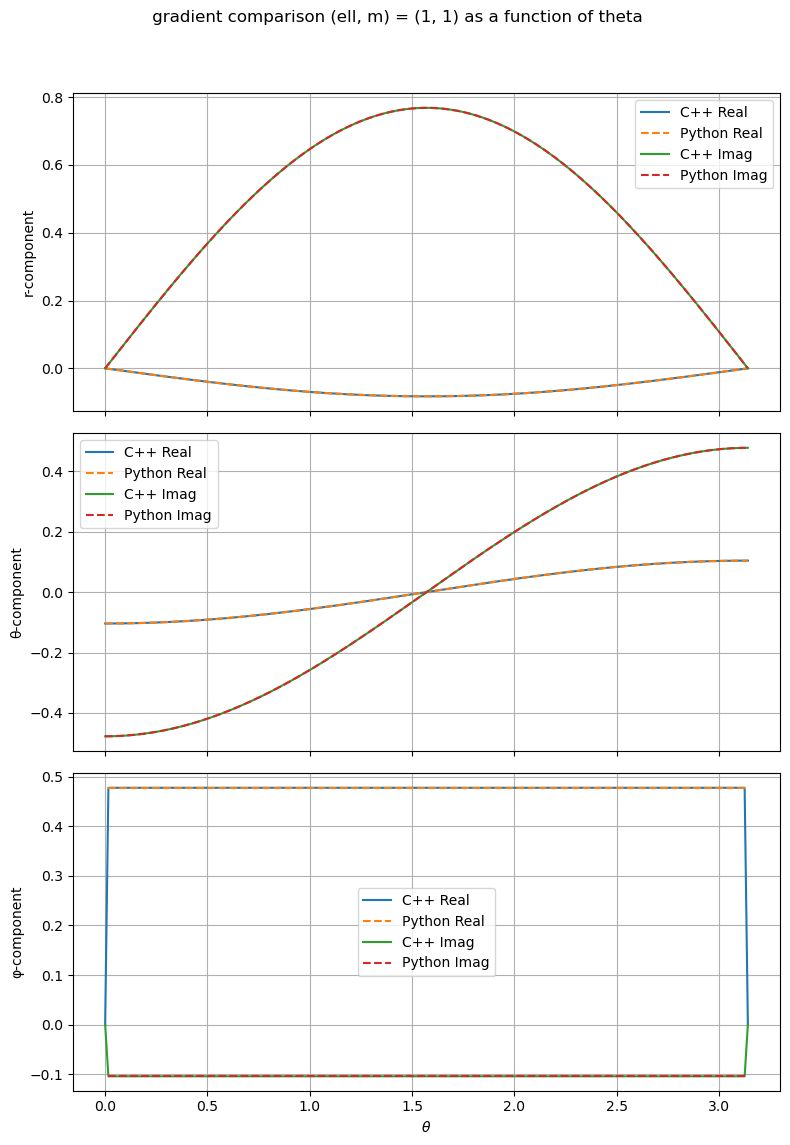

Plotting NormalDV_phi1_1.txt...


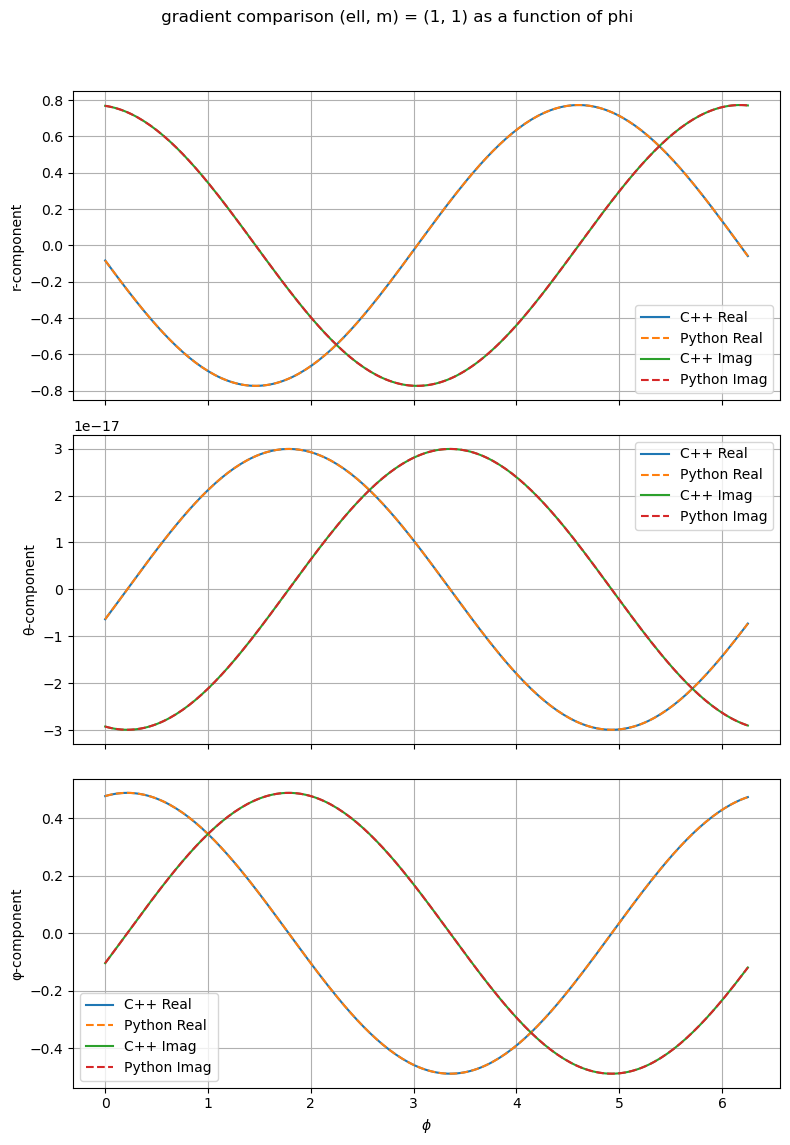

Plotting NormalDV_r0_0.txt...


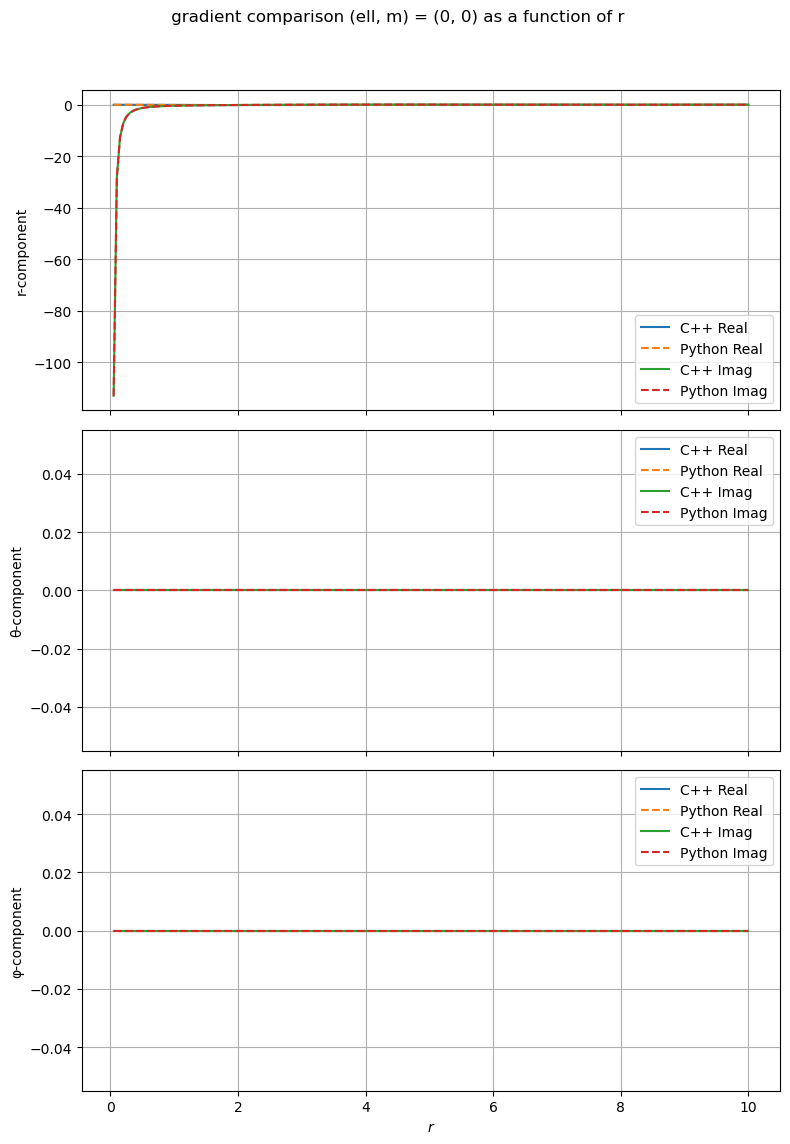

Plotting NormalDV_phi1_-1.txt...


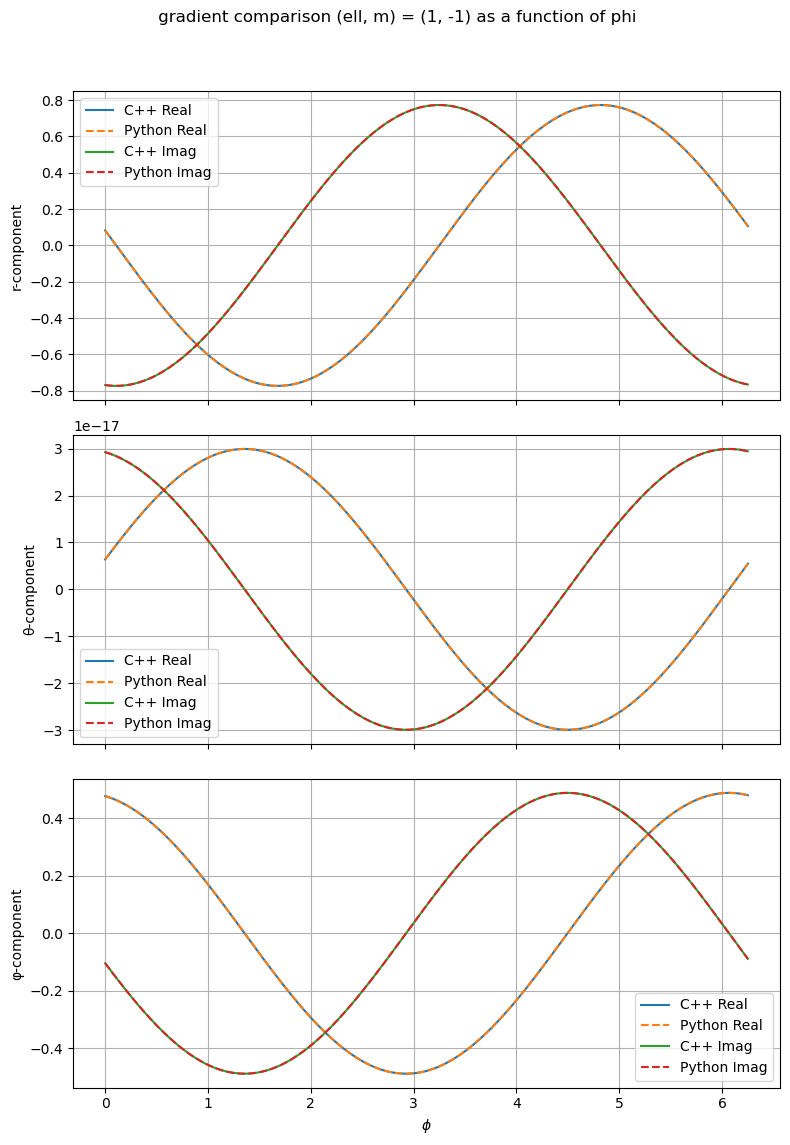

Plotting NormalDV_r1_-1.txt...


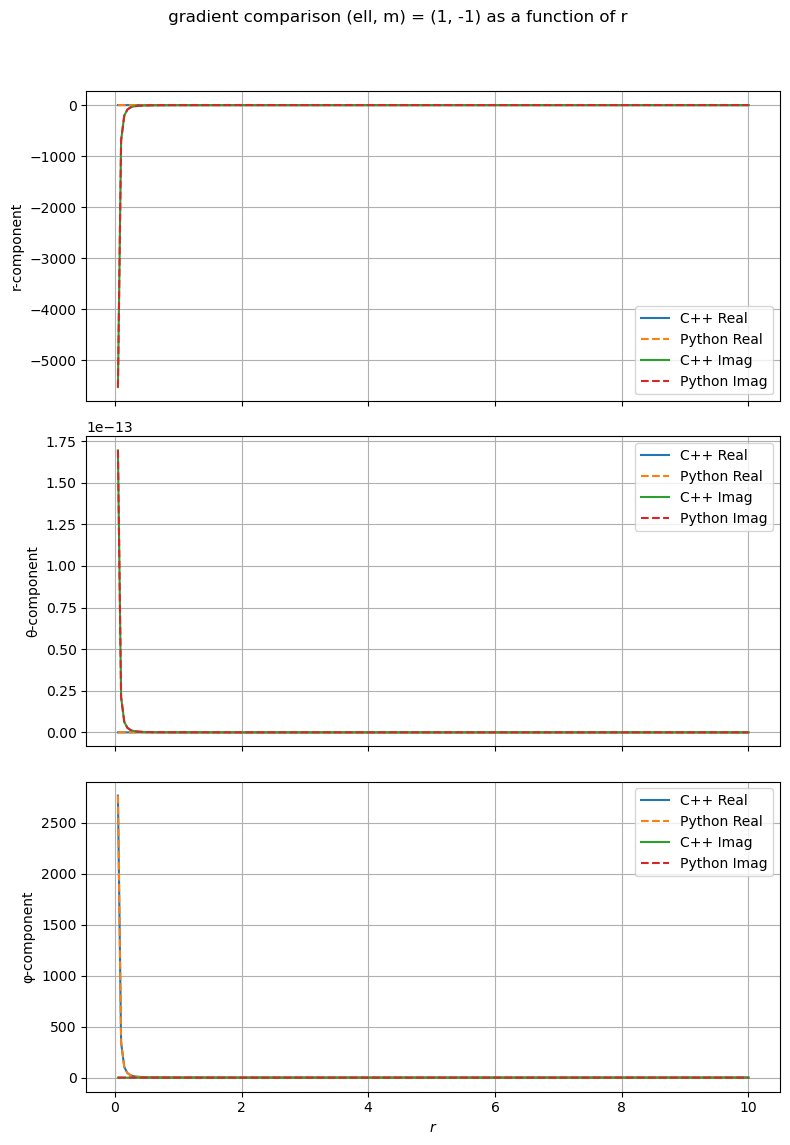

Plotting NormalDV_theta1_-1.txt...


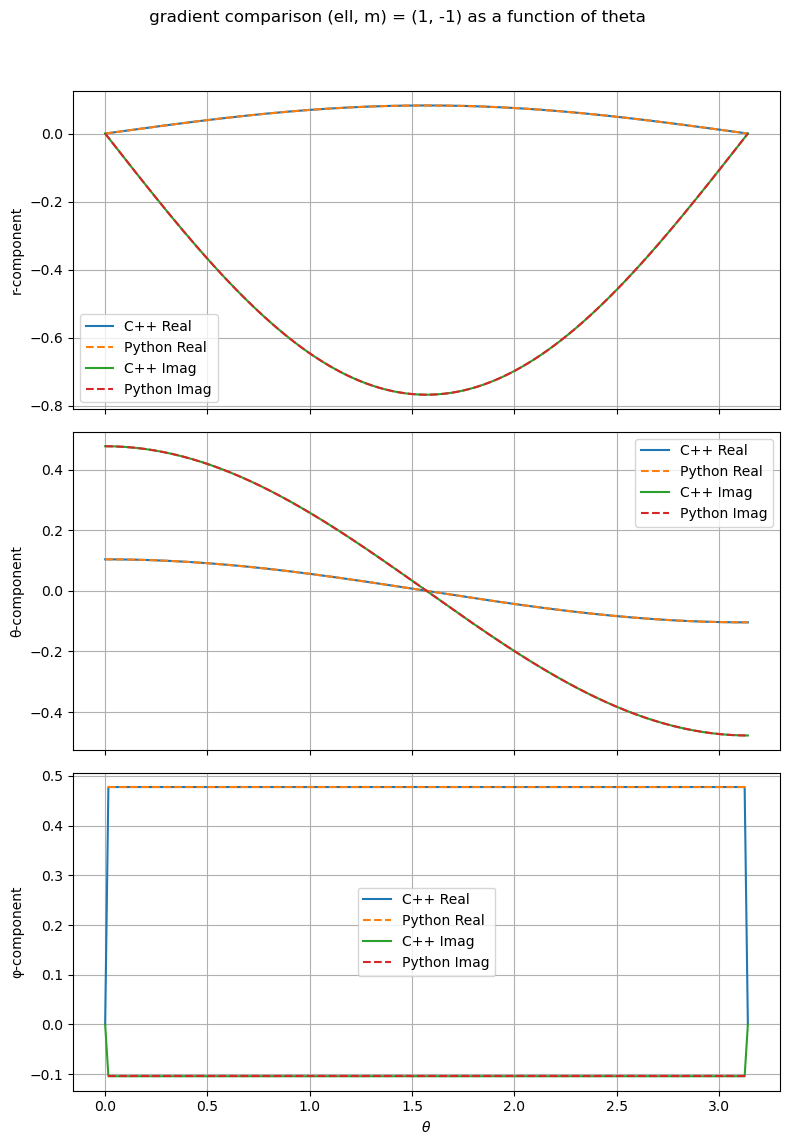

Plotting NormalDV_r1_1.txt...


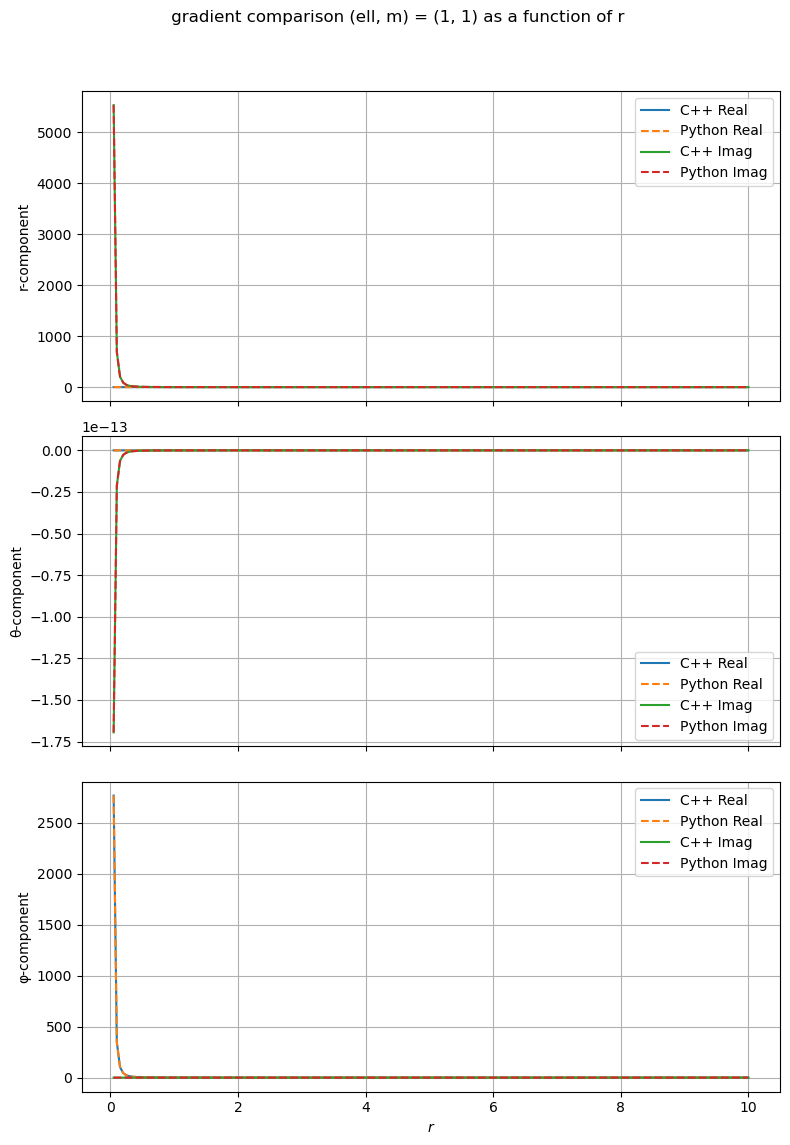

Plotting NormalDV_r1_0.txt...


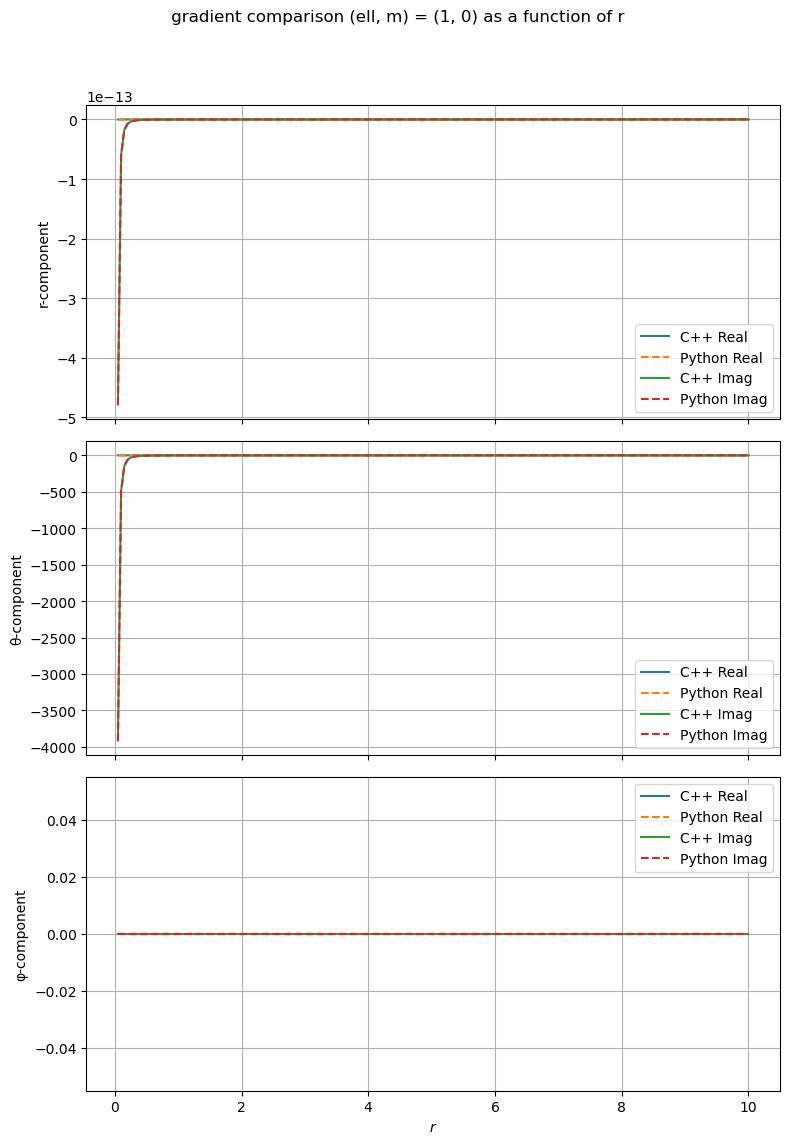

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os

def load_gradient_file(filename, root="data/"):
    """Load expected gradient from file and extract ell, m from header"""
    filepath = os.path.join(root, filename)
    with open(filepath, 'r') as f:
        header = f.readline().strip()
        lines = f.readlines()

    # Extract variable type and ell, m values
    # Example header: "theta, (n,m): (1,1)"
    match = re.match(r'(\w+),\s*\(n,m\):\s*\(([-0-9]+),\s*([-0-9]+)\)', header)
    if match:
        var_name = match.group(1)
        ell_val = int(match.group(2))
        m_val = int(match.group(3))
    else:
        var_name, ell_val, m_val = "variable", None, None

    # Parse gradient tuples
    x_vals, r_comp, theta_comp, phi_comp = [], [], [], []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        parts = line.split(":")
        x_val = float(parts[0])
        x_vals.append(x_val)
        tuples = re.findall(r'\(([0-9eE\+\-\.]+),([0-9eE\+\-\.]+)\)', parts[1])
        if len(tuples) != 3:
            raise ValueError(f"Expected 3 gradient components, got {len(tuples)} in line: {line}")
        r_comp.append([float(tuples[0][0]), float(tuples[0][1])])
        theta_comp.append([float(tuples[1][0]), float(tuples[1][1])])
        phi_comp.append([float(tuples[2][0]), float(tuples[2][1])])
    
    return var_name, ell_val, m_val, np.array(x_vals), np.array(r_comp), np.array(theta_comp), np.array(phi_comp)

def plot_compare_gradient_auto_subplots(filename, root="data/"):
    # Load expected data and ell, m
    var_name, ell, m, x, r_exp, theta_exp, phi_exp = load_gradient_file(filename, root=root)

    # Determine points for computation based on varying variable
    if var_name == "r":
        r_vals = x
        theta_vals = np.full_like(x, np.pi/2)
        phi_vals = np.full_like(x, 0)
    elif var_name == "theta":
        r_vals = np.full_like(x, 1)
        theta_vals = x
        phi_vals = np.full_like(x, 0)
    elif var_name == "phi":
        r_vals = np.full_like(x, 1)
        theta_vals = np.full_like(x, np.pi/2)
        phi_vals = x

    # Compute gradients
    grad_r, grad_theta, grad_phi = NormalDVPsiGradient(ell, m, r_vals, theta_vals, phi_vals)
    # grad_r, grad_theta, grad_phi = spherical_gradient(
    #     Psi(ell, m, r_vals, theta_vals, phi_vals),
    #     r_vals, theta_vals, phi_vals, vary=var_name
    # )

    # Combine components for plotting
    components = [(r_exp, grad_r, "r"), (theta_exp, grad_theta, "θ"), (phi_exp, grad_phi, "φ")]
    var_map = {"theta": r"$\theta$", "phi": r"$\phi$", "r": r"$r$"}
    var_label = var_map.get(var_name, var_name)

    # Create a single figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

    for ax, (exp, comp, label) in zip(axes, components):
        ax.plot(x, exp[:,0], '-', label="C++ Real")
        ax.plot(x, comp.real, '--', label="Python Real")
        ax.plot(x, exp[:,1], '-', label="C++ Imag")
        ax.plot(x, comp.imag, '--', label="Python Imag")
        # ax.plot(x, comp.real - exp[:,0], '-', label="Diff Real")
        # ax.plot(x, comp.imag - exp[:,1], '-', label="Diff Imag")
        ax.set_ylabel(f"{label}-component")
        ax.legend()
        ax.grid(True)

    axes[-1].set_xlabel(var_label)
    fig.suptitle(f" gradient comparison (ell, m) = ({ell}, {m}) as a function of {var_name}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

        
import os

def plot_all_gradients_in_directory(root="data/"):
    # List all files in the data directory
    files = [f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]

    # Filter for files that match the expected pattern (e.g., "NormalDV_*.txt")
    gradient_files = [f for f in files if f.startswith("NormalDV_") and f.endswith(".txt")]

    # Plot each gradient file
    for filename in gradient_files:
        print(f"Plotting {filename}...")
        plot_compare_gradient_auto_subplots(filename, root=root)

plot_all_gradients_in_directory()





Plotting Psi_phi1_1.txt...


/var/folders/3k/hy9hsqdx2rn3xs7l4zq8q6480000gn/T/ipykernel_24919/1327875857.py:16: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y = sp.sph_harm(m, ell, phi, theta)  # note: sph_harm args are (m, ell, phi, theta)


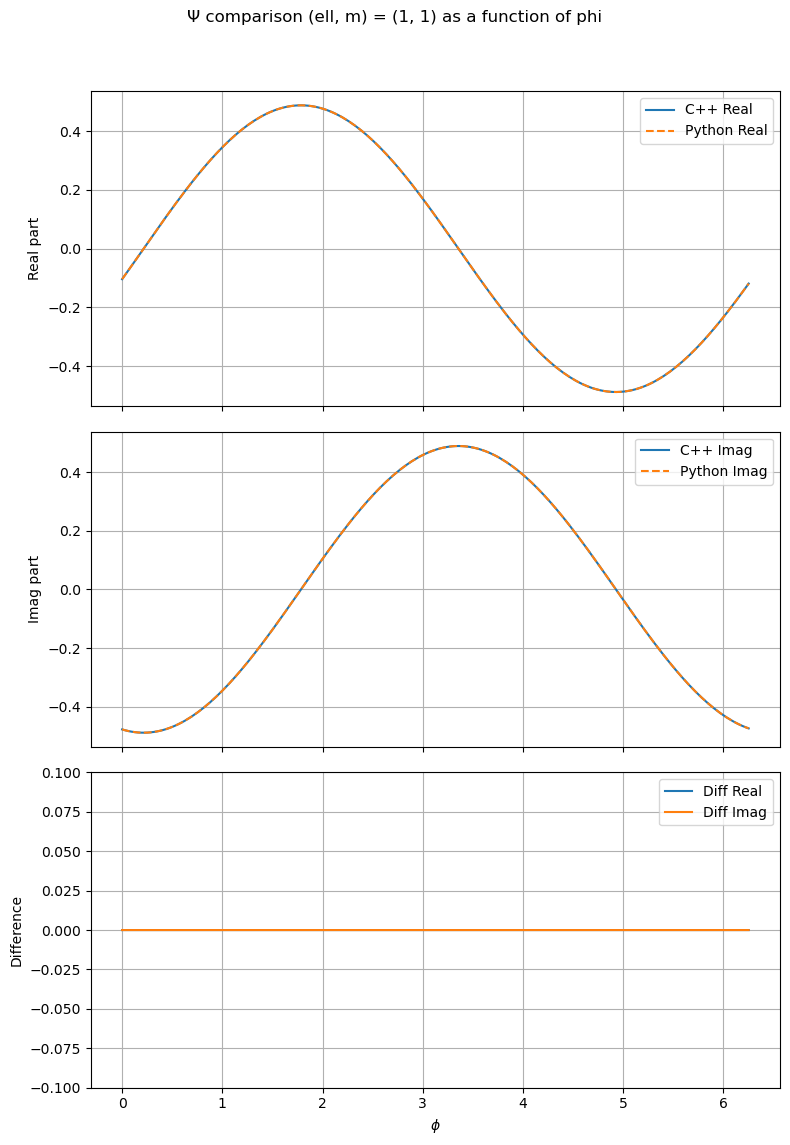

Plotting Psi_phi1_-1.txt...


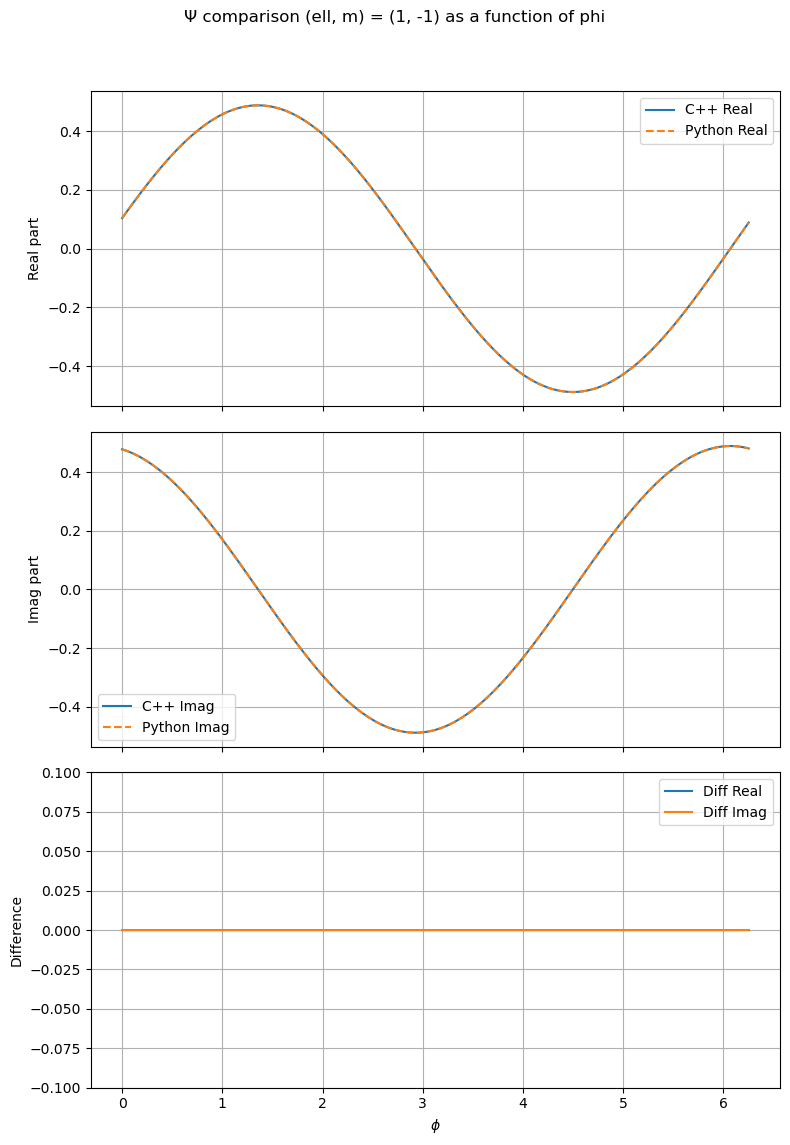

Plotting Psi_phi1_0.txt...


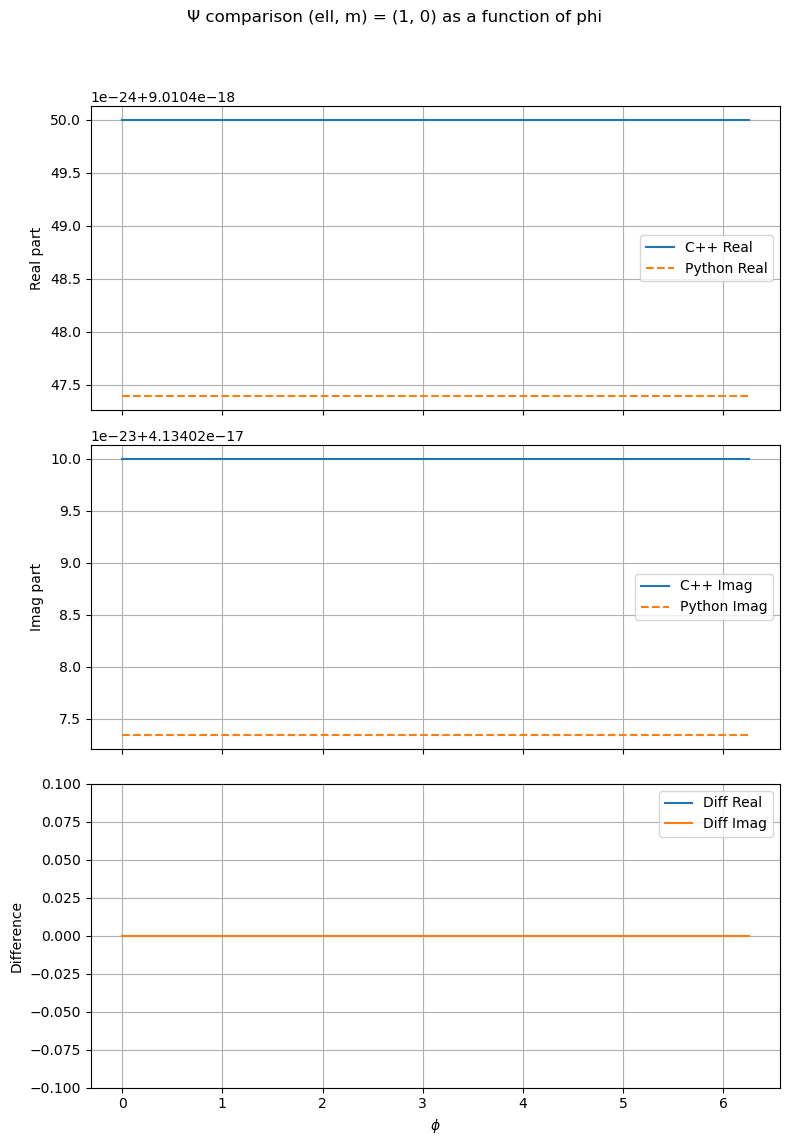

Plotting Psi_r1_1.txt...


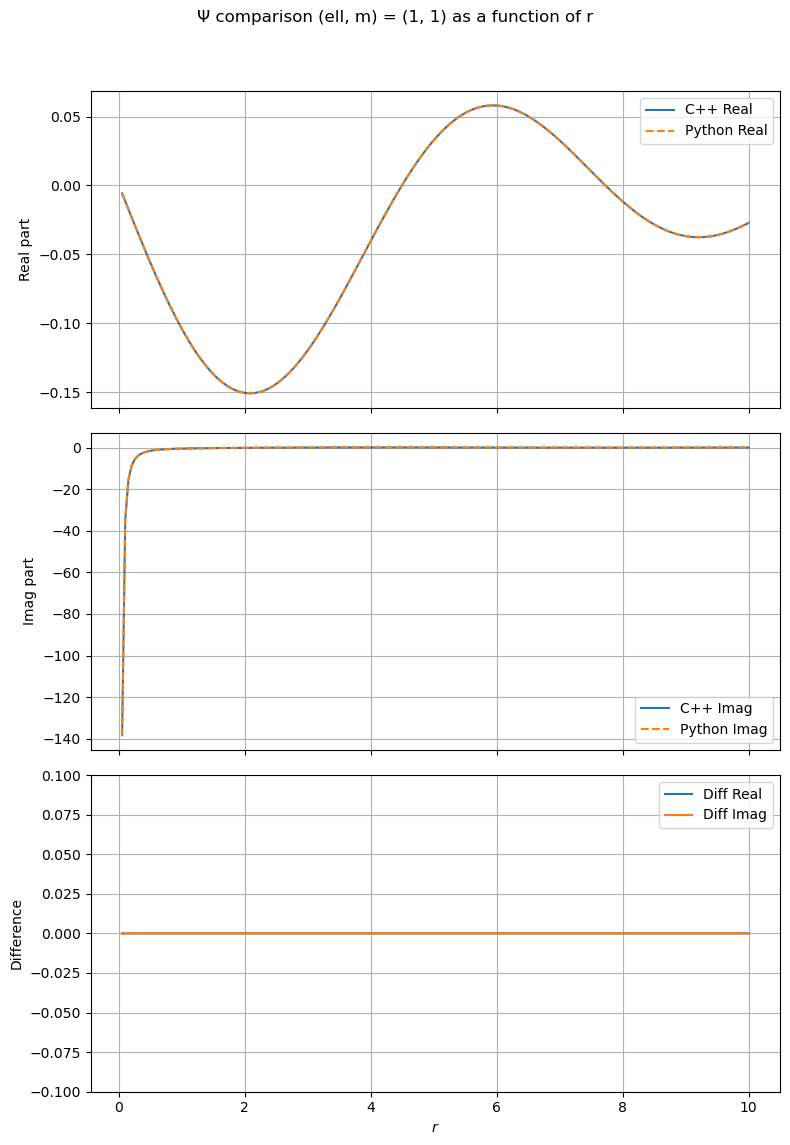

Plotting Psi_r1_0.txt...


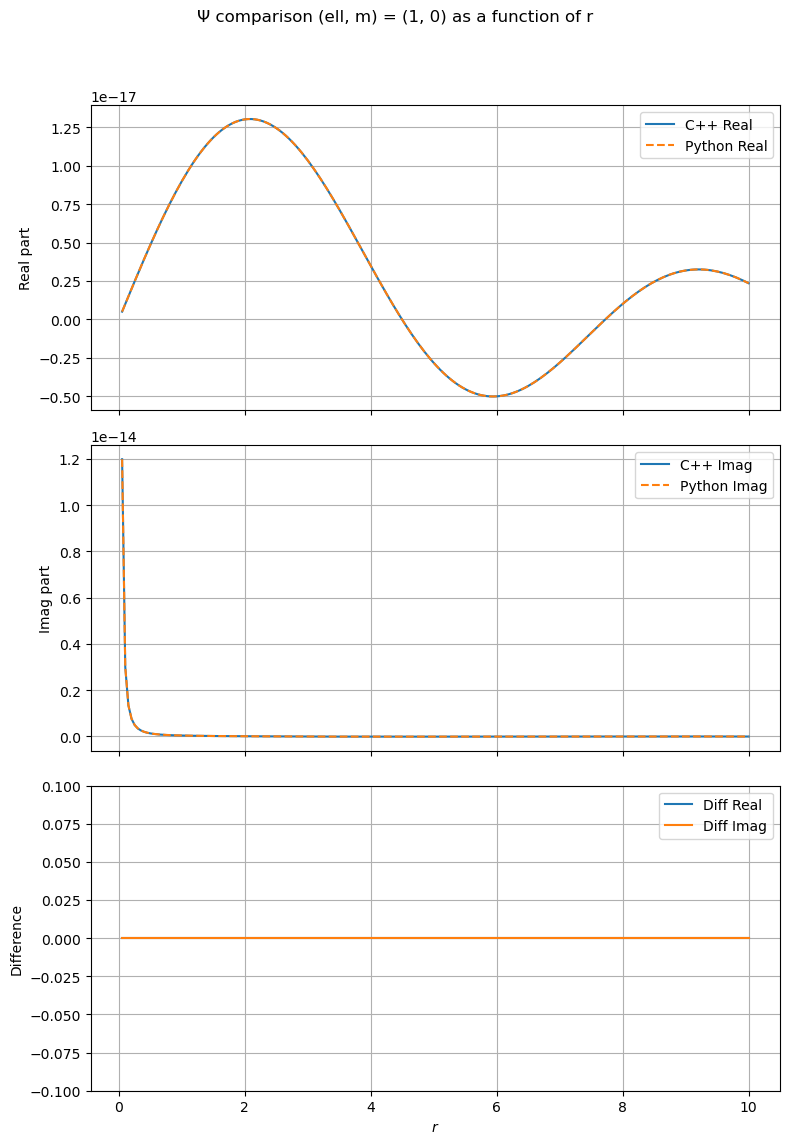

Plotting Psi_r1_-1.txt...


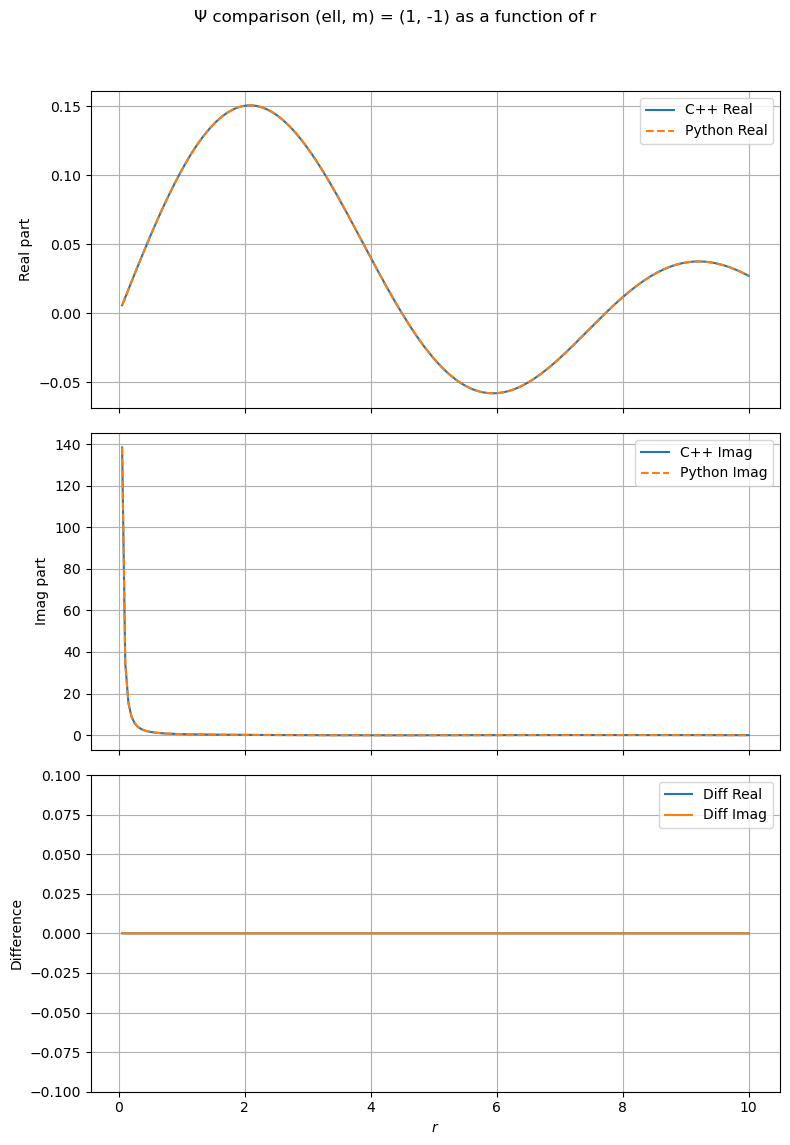

Plotting Psi_r0_0.txt...


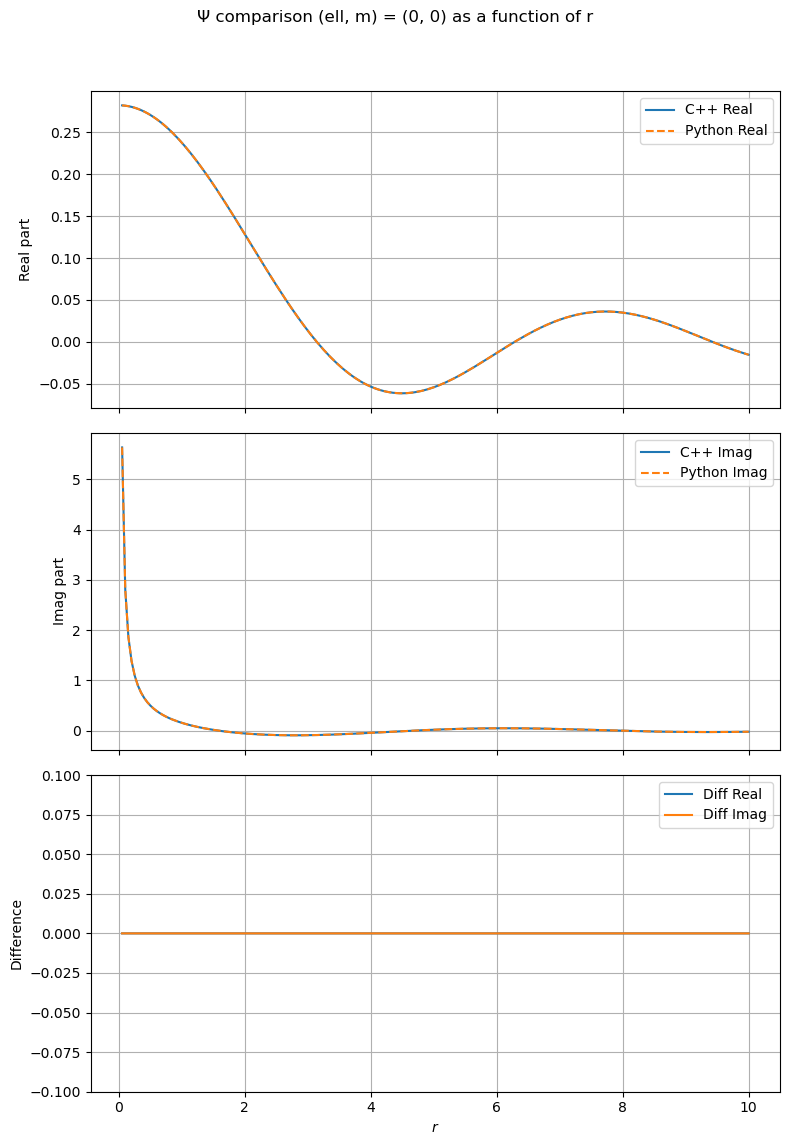

Plotting Psi_phi0_0.txt...


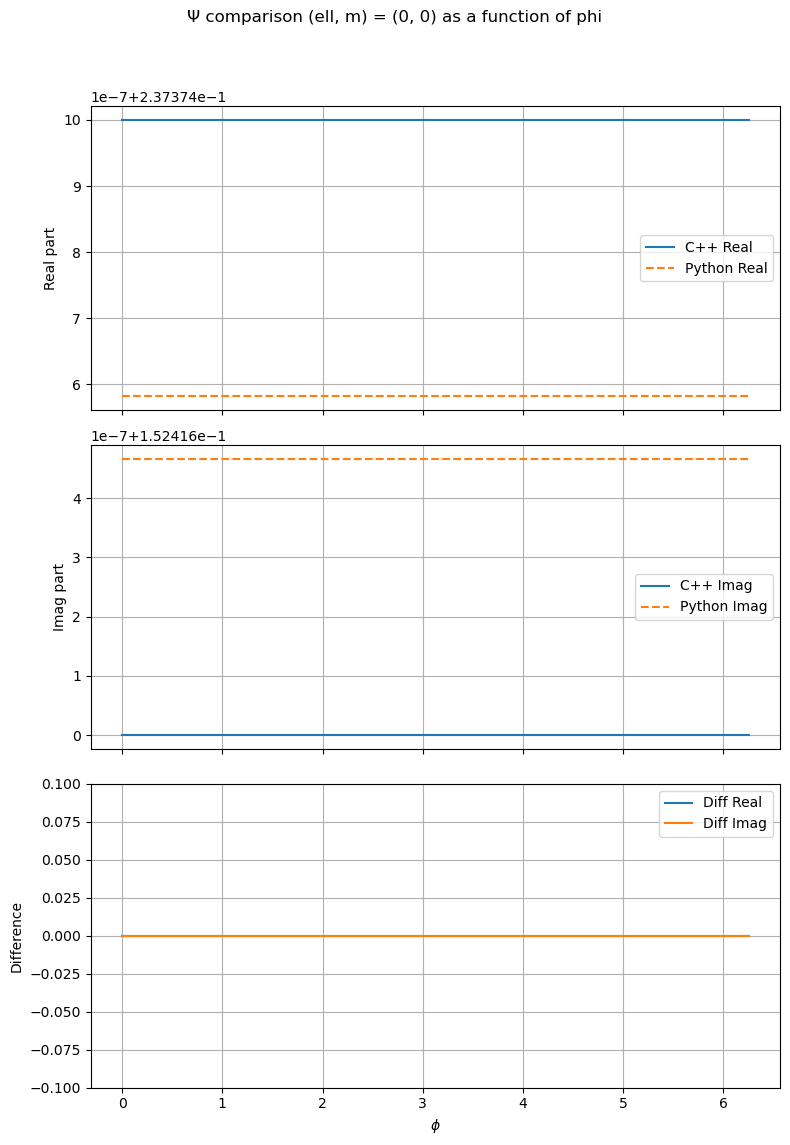

Plotting Psi_theta0_0.txt...


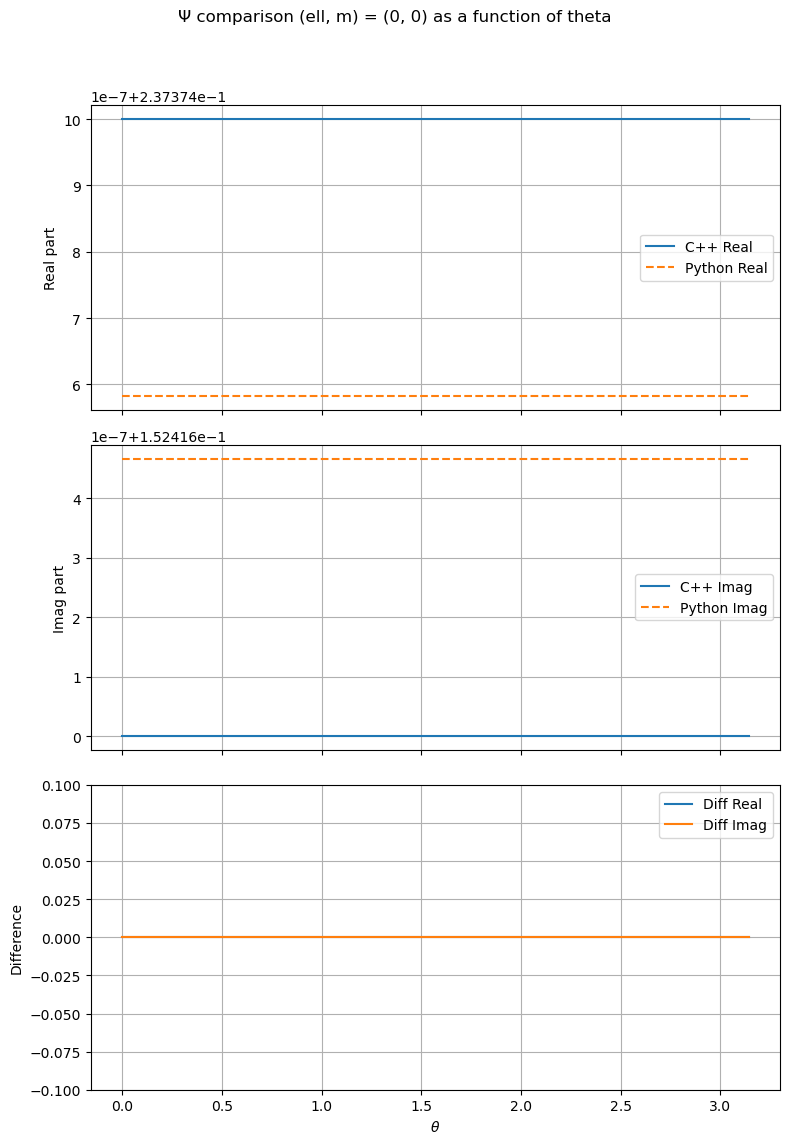

Plotting Psi_theta1_1.txt...


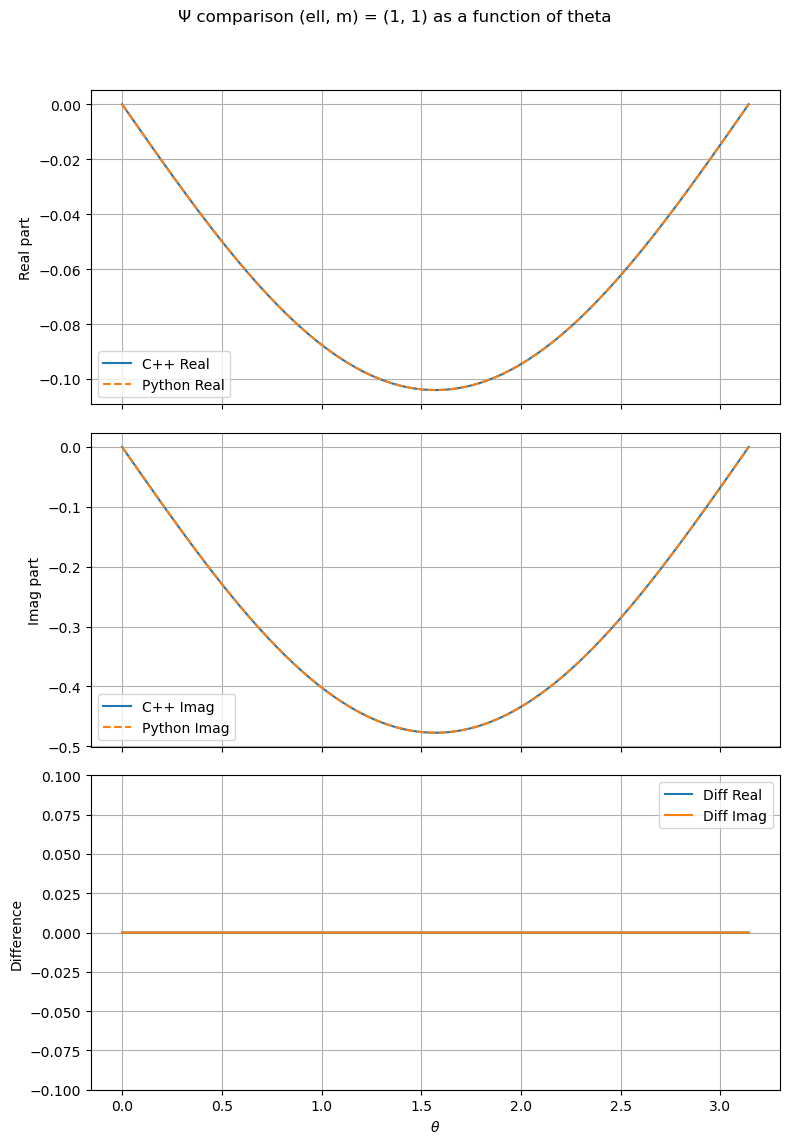

Plotting Psi_theta1_0.txt...


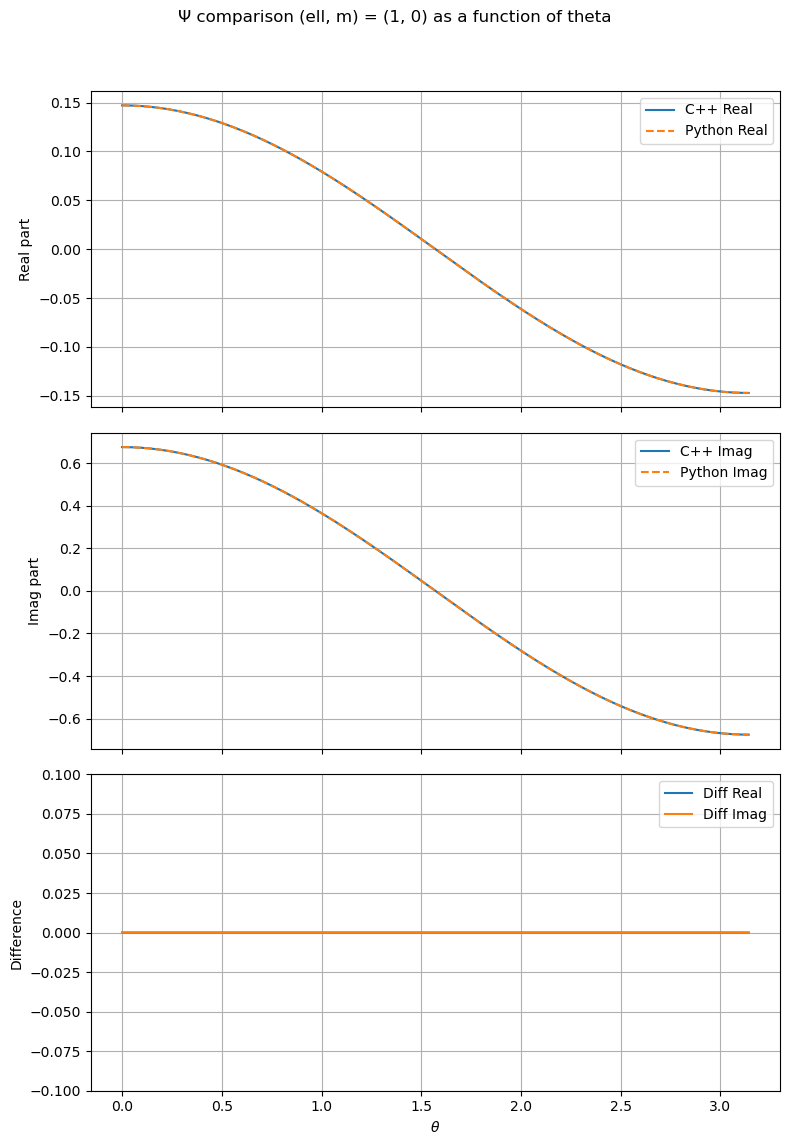

Plotting Psi_theta1_-1.txt...


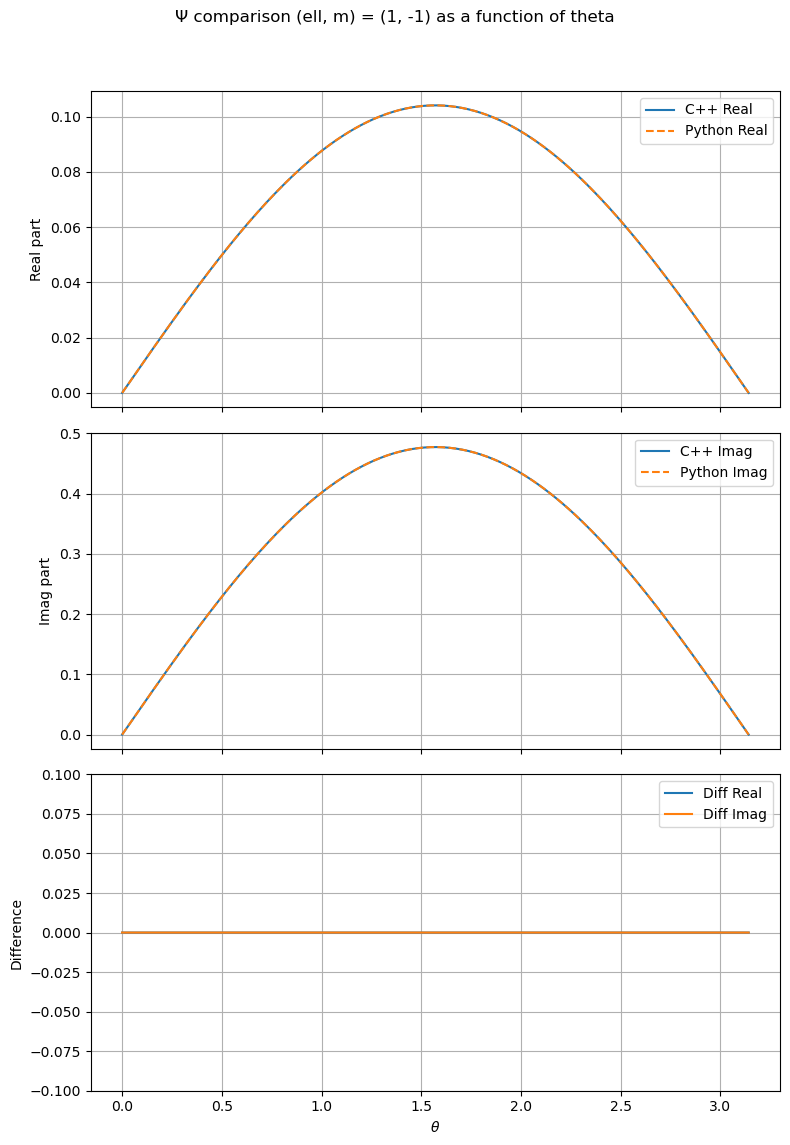

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import scipy.special as sp
from mpmath import hankel2

# --- Your Psi function ---
def hankel_2(n, z):
    """Wrapper for spherical Hankel of the second kind h_n^(2)(z)."""
    # scipy.special has spherical_jn, spherical_yn, but not hankel directly.
    return sp.spherical_jn(n, z) - 1j * sp.spherical_yn(n, z)

def Psi(ell, m, r, theta, phi):
    h2 = hankel_2(ell, r)
    Y = sp.sph_harm(m, ell, phi, theta)  # note: sph_harm args are (m, ell, phi, theta)
    return h2 * Y


# --- File loading ---
def load_psi_file(filename, root="data/"):
    """Load Psi values from file and extract ell, m from header"""
    filepath = os.path.join(root, filename)
    with open(filepath, 'r') as f:
        header = f.readline().strip()
        lines = f.readlines()

    # Example header: "r, (n,m): (1,0)"
    match = re.match(r'(\w+),\s*\(n,m\):\s*\(([-0-9]+),\s*([-0-9]+)\)', header)
    if match:
        var_name = match.group(1)
        ell_val = int(match.group(2))
        m_val = int(match.group(3))
    else:
        var_name, ell_val, m_val = "variable", None, None

    # Parse Psi values
    x_vals, psi_vals = [], []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        parts = line.split(":")
        x_val = float(parts[0])
        x_vals.append(x_val)

        tup = re.findall(r'\(([0-9eE\+\-\.]+),([0-9eE\+\-\.]+)\)', parts[1])
        if len(tup) != 1:
            raise ValueError(f"Expected 1 Psi value, got {len(tup)} in line: {line}")
        real, imag = float(tup[0][0]), float(tup[0][1])
        psi_vals.append(real + 1j * imag)

    return var_name, ell_val, m_val, np.array(x_vals), np.array(psi_vals)


# --- Plotting ---
def plot_compare_psi(filename, root="data/", show_diff=False):
    # Load expected Psi values
    var_name, ell, m, x, psi_vals = load_psi_file(filename, root=root)

    # Compute Psi values from Python
    if var_name == "r":
        psi_comp = Psi(ell, m, x, np.full_like(x, np.pi/2), np.full_like(x, 0))
    elif var_name == "theta":
        psi_comp = Psi(ell, m, np.full_like(x, 1), x, np.full_like(x, 0))
    elif var_name == "phi":
        psi_comp = Psi(ell, m, np.full_like(x, 1), np.full_like(x, np.pi/2), x)
    else:
        raise ValueError(f"Unknown variable name {var_name}")

    # Labels
    var_map = {"theta": r"$\theta$", "phi": r"$\phi$", "r": r"$r$"}
    var_label = var_map.get(var_name, var_name)

    # Plot comparison
    nrows = 3 if show_diff else 2
    fig, ax = plt.subplots(nrows, 1, figsize=(8, 4*nrows), sharex=True)

    ax[0].plot(x, psi_vals.real, '-', label="C++ Real")
    ax[0].plot(x, psi_comp.real, '--', label="Python Real")
    ax[0].set_ylabel("Real part")
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(x, psi_vals.imag, '-', label="C++ Imag")
    ax[1].plot(x, psi_comp.imag, '--', label="Python Imag")
    ax[1].set_ylabel("Imag part")
    ax[1].legend()
    ax[1].grid(True)

    if show_diff:
        diff = psi_comp - psi_vals
        ax[2].plot(x, diff.real, '-', label="Diff Real")
        ax[2].plot(x, diff.imag, '-', label="Diff Imag")
        ax[2].set_ylim([-0.1, 0.1])
        ax[2].set_ylabel("Difference")
        ax[2].legend()
        ax[2].grid(True)

    ax[-1].set_xlabel(var_label)
    fig.suptitle(f"Ψ comparison (ell, m) = ({ell}, {m}) as a function of {var_name}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_all_psi_in_directory(root="data/", show_diff=False):
    # List all files in the data directory
    files = [f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]
    psi_files = [f for f in files if f.startswith("Psi_") and f.endswith(".txt")]

    for filename in psi_files:
        print(f"Plotting {filename}...")
        plot_compare_psi(filename, root=root, show_diff=show_diff)


# Example call:
plot_all_psi_in_directory(show_diff=True)
